## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [13]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [14]:
train, test = keras.datasets.cifar10.load_data()

In [15]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [16]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units= 10, num_neurons= [512, 128, 32]):
    
    #輸入層
    input_layer= keras.layers.Input(input_shape)
    
    #隱藏層
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x= keras.layers.Dense(units=n_units,
                                  activation='relu',
                                  name='hidden_layers'+str(i+1))(input_layer)
            x= BatchNormalization()(x)
        else:
            x= keras.layers.Dense(units=n_units,
                                  activation='relu',
                                  name='hidden_layers'+str(i+1))(x)
            x= BatchNormalization()(x)
    
    #輸出層
    output_layer= keras.layers.Dense(units=output_units,
                                     activation='softmax',
                                     name='output_layer')(x)
    
    #建模
    model= keras.models.Model(inputs=[input_layer], outputs=[output_layer])    
    return model

In [18]:
Learning_rate= 1e-3
Epochs= 50
Batch_size= 500
Momentum= 0.95

In [21]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [22]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

model_checkpoint_1= ModelCheckpoint(filepath='./tmp.h5',
                                    monitor='val_loss',
                                    save_best_only=True)

In [19]:
#呼叫建模，設定係數及優化器，儲存過程數據
#暫存字典
results = {}
keras.backend.clear_session()
#呼叫模型
model= build_mlp(input_shape= x_train.shape[1:])
#呼叫模型概況
model.summary()
#設定優化器
optimizer= keras.optimizers.SGD(lr= Learning_rate, nesterov= True, momentum= Momentum)
#設定輸出結果
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
#機器學習
model.fit(x_train,y_train,
          epochs= Epochs,
          batch_size= Batch_size,
          validation_data= (x_test, y_test),
          shuffle= True,
          callbacks= [model_checkpoint_1])

#儲存模型
model.save('model_1.h5')
model.save_weights('model_1_weights.h5')

#資料蒐集
train_loss= model.history.history['loss']
valid_loss= model.history.history['val_loss']
train_acc= model.history.history['accuracy']
valid_acc= model.history.history['val_accuracy']

model_1_pred= model.predict(x_test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layers3 (Dense)       (None, 32)                4128      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128 

50000/50000 [==============================] - 2s 32us/step - loss: 0.4683 - accuracy: 0.8484 - val_loss: 2.0532 - val_accuracy: 0.4589
Epoch 47/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.4530 - accuracy: 0.8546 - val_loss: 2.0974 - val_accuracy: 0.4666
Epoch 48/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.4376 - accuracy: 0.8609 - val_loss: 2.1907 - val_accuracy: 0.4550
Epoch 49/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.4247 - accuracy: 0.8644 - val_loss: 2.0526 - val_accuracy: 0.4698
Epoch 50/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.4091 - accuracy: 0.8710 - val_loss: 2.2428 - val_accuracy: 0.4498


In [23]:
# reload model & testing prediction
model_loadback= keras.models.load_model('./tmp.h5')
loss_lb_1, acc_lb_1= model_loadback.evaluate(x_test, y_test)
model_loadback_ms= keras.models.load_model('./model_1.h5')
loss_lb_2, acc_lb_2= model_loadback_ms.evaluate(x_test, y_test)
print('Best_loss:%.5f,%.5f' % (loss_lb_1, loss_lb_2))
print('Best_accuracy:%.5f,%.5f' % (acc_lb_1, acc_lb_2))

#可以知道 model save是儲存最後一個模型，但是model checkpoint則是儲存最佳模型

10000/10000 [==============================] - 1s 68us/step
Best_loss:1.47847,2.24282
Best_accuracy:0.48070,0.44980


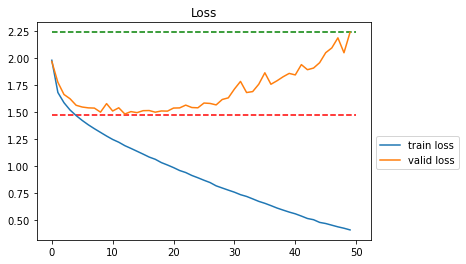

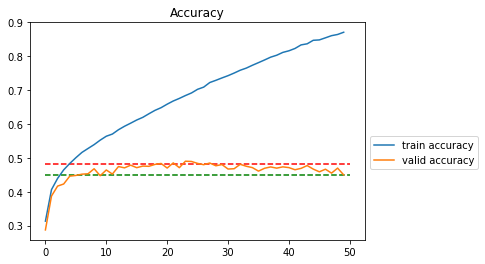

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_lb_1, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.hlines(y=loss_lb_2, xmin=0, xmax=len(train_loss), colors='g', linestyles='--')

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_lb_1, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.hlines(y=acc_lb_2, xmin=0, xmax=len(train_loss), colors='g', linestyles='--')

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy")
plt.show()

# Answer bonus

In [27]:
from sklearn.metrics import accuracy_score

pred_loadback= model_loadback.predict(x_test)

final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=model_1_pred.argmax(axis=-1))
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

print("Accuracy of final weights: %.3f" % final_model_acc)
print("Accuracy of best weights: %.3f" % loadback_acc)

Accuracy of final weights: 0.450
Accuracy of best weights: 0.481


In [29]:
new_model = build_mlp(input_shape=x_train.shape[1:])
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_acc)

new_model.load_weights("./model_1_weights.h5")
new_model_pred = new_model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)

Accuracy of best weights: 0.105
Accuracy of best weights: 0.450
